# preparing the data and workflow

The problem it to predict customres who can not be able to pay the car loan using machin learning models and choose one with the best effect

## My aim is to create models that they can predict which customer will be in a churn score

## Set the view and install necessary libraries

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta, date
import re
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
from matplotlib.pyplot import figure



from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin




from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.tree import DecisionTreeClassifier

from scipy.stats.distributions import uniform, randint

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn import  metrics


import xgboost



In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## Download the data set

Full data you can find here:
https://www.kaggle.com/sneharshinde/ltfs-av-data

In [4]:
dataset = pd.read_csv('train.csv')
dataset.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,03-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,26-09-18,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,01-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,26-10-18,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,26-09-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


In [5]:
dataset['loan_default'].value_counts()

0    182543
1     50611
Name: loan_default, dtype: int64

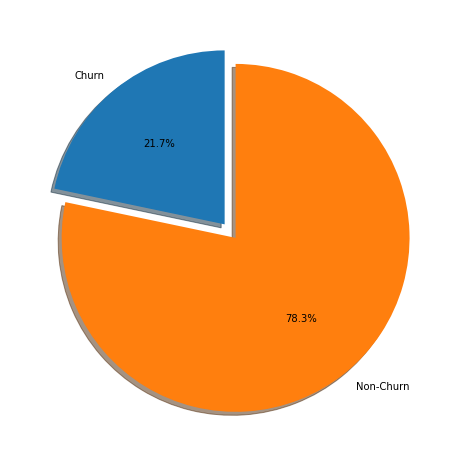

In [6]:
labels = 'Churn','Non-Churn'
sizes = [dataset['loan_default'][dataset['loan_default']==1].count(),dataset['loan_default'][dataset['loan_default']==0].count()]
explode = (0,0.1)
fig1, ax1 = plt.subplots(figsize=(10,8))
ax1.pie(sizes,explode=explode,labels=labels,autopct = '%1.1f%%',shadow=True,startangle = 90)
ax1.axit = 'equel'

## Because the dataset is too big and unbalanced, I will work on the (balanced) part of it

In [7]:
# val_true = dataset[dataset['loan_default']==1]
# val_false = dataset[dataset['loan_default']==0]

# val_false.reset_index(drop=True)
# val_true.reset_index(drop=True)

# val_false=val_false.sample(n=8_000, random_state=1)


# val_true=val_true.sample(n=10_000, random_state=1)    


# dataset = pd.concat([val_true,val_false])
# dataset.reset_index(drop=True) 
dataset = dataset.groupby('loan_default').sample(n=15_000, random_state=1) # po 15k każdy 50/50
dataset['loan_default'].value_counts()

0    15000
1    15000
Name: loan_default, dtype: int64

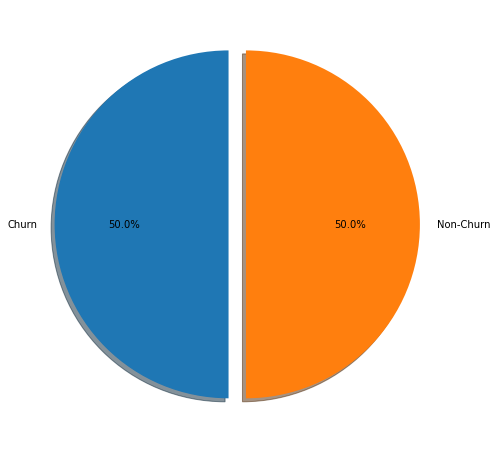

In [8]:
labels = 'Churn','Non-Churn'
sizes = [dataset['loan_default'][dataset['loan_default']==1].count(),dataset['loan_default'][dataset['loan_default']==0].count()]
explode = (0,0.1)
fig1, ax1 = plt.subplots(figsize=(10,8))
ax1.pie(sizes,explode=explode,labels=labels,autopct = '%1.1f%%',shadow=True,startangle = 90)
ax1.axit = 'equel'

## Checking how the data looks like


In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 185068 to 22532
Data columns (total 41 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   UniqueID                             30000 non-null  int64  
 1   disbursed_amount                     30000 non-null  int64  
 2   asset_cost                           30000 non-null  int64  
 3   ltv                                  30000 non-null  float64
 4   branch_id                            30000 non-null  int64  
 5   supplier_id                          30000 non-null  int64  
 6   manufacturer_id                      30000 non-null  int64  
 7   Current_pincode_ID                   30000 non-null  int64  
 8   Date.of.Birth                        30000 non-null  object 
 9   Employment.Type                      29045 non-null  object 
 10  DisbursalDate                        30000 non-null  object 
 11  State_ID               

In [10]:
dataset.describe()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,loan_default
count,30000.000000,30000.000000,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.0,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.0000,30000.000000,3.000000e+04,3.000000e+04,3.000000e+04,30000.000000,30000.000000,30000.000000,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000
mean,537298.262500,54902.175733,75801.92900,75.503265,73.801067,19726.072067,68.611767,3451.897733,7.343933,1560.053733,1.0,0.831567,0.075933,0.155600,0.021467,0.002000,275.064733,2.329067,0.9968,0.175267,1.551751e+05,1.987738e+05,1.982191e+05,0.055533,0.025733,0.006900,5.020136e+03,6.949684e+03,6.841696e+03,1.231963e+04,2.660090e+02,0.361233,0.106433,0.222367,0.500000
std,69391.538431,12499.916198,18135.27007,11.067965,70.332047,3475.155345,22.274353,2248.551334,4.459511,975.489575,0.0,0.374257,0.264896,0.362482,0.144936,0.044677,331.809015,5.074837,2.0336,0.579102,8.562756e+05,1.096762e+06,1.096867e+06,0.579190,0.274725,0.105764,1.597036e+05,1.886175e+05,1.881759e+05,1.584663e+05,9.911172e+03,0.915153,0.401884,0.738605,0.500008
min,417428.000000,13369.000000,38055.00000,10.030000,1.000000,10524.000000,45.000000,1.000000,1.000000,1.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,-6.678296e+06,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,-1.030000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,476397.000000,47845.000000,65703.00000,69.940000,14.000000,16605.000000,48.000000,1515.000000,4.000000,721.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
50%,538888.000000,54259.000000,70931.50000,77.760000,62.000000,20478.000000,86.000000,2989.000000,6.000000,1475.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.500000
75%,598333.250000,60947.000000,79495.75000,84.080000,130.000000,23029.000000,86.000000,5729.000000,11.000000,2379.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,652.000000,3.000000,1.0000,0.000000,3.081300e+04,5.646350e+04,5.508650e+04,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.983250e+03,0.000000e+00,0.000000,0.000000,0.000000,1.000000
max,658670.000000,191392.000000,255315.00000,95.000000,261.000000,24793.000000,145.000000,7343.000000,22.000000,3789.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,879.000000,194.000000,144.0000,19.000000,4.351615e+07,9.262282e+07,9.262873e+07,37.000000,15.000000,6.000000,1.963828e+07,1.980000e+07,1.980000e+07,1.501991e+07,1.113118e+06,19.000000,12.000000,19.000000,1.000000


## Checking where are NaN values

In [11]:
dataset.isnull().sum()

UniqueID                                 0
disbursed_amount                         0
asset_cost                               0
ltv                                      0
branch_id                                0
supplier_id                              0
manufacturer_id                          0
Current_pincode_ID                       0
Date.of.Birth                            0
Employment.Type                        955
DisbursalDate                            0
State_ID                                 0
Employee_code_ID                         0
MobileNo_Avl_Flag                        0
Aadhar_flag                              0
PAN_flag                                 0
VoterID_flag                             0
Driving_flag                             0
Passport_flag                            0
PERFORM_CNS.SCORE                        0
PERFORM_CNS.SCORE.DESCRIPTION            0
PRI.NO.OF.ACCTS                          0
PRI.ACTIVE.ACCTS                         0
PRI.OVERDUE

There is only one column with NaN valuse: Employment.Type

## Checking how looks like churn / non-churn split

In [12]:
dataset['loan_default'].value_counts()

0    15000
1    15000
Name: loan_default, dtype: int64

## Change AVERAGE.ACCT.AGE and CREDIT.HISTORY.LENGTH from string value into numeric

In [13]:
dataset[['AVERAGE_y','AVERAGE_m']]= [x.split(' ') for x in dataset['AVERAGE.ACCT.AGE']]
dataset['AVERAGE_y']  = [ re.sub("[^0-9]", "", x) for x in dataset['AVERAGE_y']]
dataset['AVERAGE_y'] = pd.to_numeric(dataset['AVERAGE_y'])
dataset['AVERAGE_m']  = [ re.sub("[^0-9]", "", x) for x in dataset['AVERAGE_m']]
dataset['AVERAGE_m']  = pd.to_numeric(dataset['AVERAGE_m'])
dataset['AVERAGE.ACCT.AGE'] =  (dataset['AVERAGE_y']*12)+ dataset['AVERAGE_m']


In [14]:
dataset[['CREDIT_y','CREDIT_m']]= [x.split(' ') for x in dataset['CREDIT.HISTORY.LENGTH']]
dataset['CREDIT_y']  = [ re.sub("[^0-9]", "", x) for x in dataset['CREDIT_y']]
dataset['CREDIT_y'] = pd.to_numeric(dataset['CREDIT_y'])
dataset['CREDIT_m']  = [ re.sub("[^0-9]", "", x) for x in dataset['CREDIT_m']]
dataset['CREDIT_m']  = pd.to_numeric(dataset['CREDIT_m'])
dataset['CREDIT.HISTORY.LENGTH'] =  (dataset['CREDIT_y']*12)+ dataset['CREDIT_m']


## Drop supperted columns

In [15]:
dataset.drop(columns=['AVERAGE_y','AVERAGE_m','CREDIT_y','CREDIT_m'],inplace=True)


## Change date to date value

In [16]:
def change_to_date(dataset,column):
    dataset[column]=[datetime.datetime.strptime(x,"%d-%m-%y").date() - timedelta(days=365.25*100) if datetime.datetime.strptime(x,"%d-%m-%y").date()  > datetime.date(year=2050,month=1,day=1) else datetime.datetime.strptime(x,"%d-%m-%y").date() for x in dataset[column]]


In [17]:
change_to_date(dataset,'Date.of.Birth')  
change_to_date(dataset,'DisbursalDate')

## To have less unique values I'll chenge date to only year in this columns and chenge it to the numbers

In [18]:
def extract_year(dataset,column):
    dataset[column]= [date.year for date in dataset[column] ]

In [19]:
extract_year(dataset,'Date.of.Birth')
#extract_year(dataset,'DisbursalDate')

## Checking number of unique values for each column

In [20]:
dataset.nunique()

UniqueID                               30000
disbursed_amount                        7271
asset_cost                             16422
ltv                                     4633
branch_id                                 82
supplier_id                             2473
manufacturer_id                            8
Current_pincode_ID                      4528
Date.of.Birth                             47
Employment.Type                            2
DisbursalDate                             84
State_ID                                  22
Employee_code_ID                        3030
MobileNo_Avl_Flag                          1
Aadhar_flag                                2
PAN_flag                                   2
VoterID_flag                               2
Driving_flag                               2
Passport_flag                              2
PERFORM_CNS.SCORE                        543
PERFORM_CNS.SCORE.DESCRIPTION             20
PRI.NO.OF.ACCTS                           74
PRI.ACTIVE

## Delete unnecessary columns

In [21]:
dataset.drop(columns=['UniqueID','MobileNo_Avl_Flag'],inplace=True)

# Prepare data to next step (train / test split) 

In [22]:
X = dataset.drop(['loan_default'], axis=1)
y = dataset['loan_default'].values




label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

print(f"X.shape: {X.shape} y.shape: { y.shape}")

X.shape: (30000, 38) y.shape: (30000,)


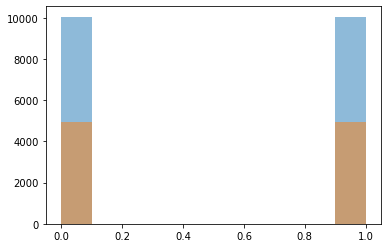

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,stratify=y)

plt.hist(y_train, alpha=0.5)
plt.hist(y_test, alpha=0.5)
plt.show()

In [24]:
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (20100, 38)
Number transactions y_train dataset:  (20100,)
Number transactions X_test dataset:  (9900, 38)
Number transactions y_test dataset:  (9900,)


## Checking data types

In [25]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20100 entries, 63126 to 178778
Data columns (total 38 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   disbursed_amount                     20100 non-null  int64  
 1   asset_cost                           20100 non-null  int64  
 2   ltv                                  20100 non-null  float64
 3   branch_id                            20100 non-null  int64  
 4   supplier_id                          20100 non-null  int64  
 5   manufacturer_id                      20100 non-null  int64  
 6   Current_pincode_ID                   20100 non-null  int64  
 7   Date.of.Birth                        20100 non-null  int64  
 8   Employment.Type                      19458 non-null  object 
 9   DisbursalDate                        20100 non-null  object 
 10  State_ID                             20100 non-null  int64  
 11  Employee_code_ID       

## Creating lists of column with numeric and non-numeric values

In [26]:
column_to_cat = list()

for column,types in zip(X_train.columns,X_train.dtypes):
    if  types =='float64' or types == 'int64':
        continue
    else:
        column_to_cat.append(column)
column_to_cat

X_train[column_to_cat]

,Employment.Type,DisbursalDate,PERFORM_CNS.SCORE.DESCRIPTION
63126,Self employed,2018-09-29,A-Very Low Risk
46920,Salaried,2018-10-31,No Bureau History Available
54524,Salaried,2018-09-06,C-Very Low Risk
106881,Self employed,2018-08-31,C-Very Low Risk
174052,Self employed,2018-08-04,No Bureau History Available
...,...,...,...
27537,Self employed,2018-09-24,C-Very Low Risk
65453,Self employed,2018-10-27,Not Scored: Not Enough Info available on the c...
21218,Self employed,2018-09-05,No Bureau History Available
14640,Self employed,2018-09-20,K-High Risk


In [27]:
column_to_num = list()

for column,types in zip(X_train.columns,X_train.dtypes):
    if  types =='float64' or types == 'int64':
        column_to_num.append(column)
    else:
        continue        
X_train[column_to_num]

,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,State_ID,Employee_code_ID,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES
63126,63713,81736,79.52,9,16120,86,5439,1991,3,1471,1,0,0,0,0,832,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,0
46920,43394,70000,62.86,16,22004,45,2992,1983,14,439,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
54524,52603,65000,82.92,67,18532,45,1513,1997,6,1613,1,0,0,0,0,738,3,2,0,101013,111455,111455,0,0,0,0,0,0,8452,0,2,0,3,6,2
106881,52303,59262,89.43,3,22732,86,49,1995,1,657,1,0,0,0,0,738,3,1,0,104182,125000,125000,0,0,0,0,0,0,12007,0,0,0,9,11,0
174052,67397,97000,73.20,202,23917,51,775,1995,18,2365,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27537,59713,69140,88.95,77,17809,86,2345,1988,4,839,1,0,0,0,0,738,23,7,0,80920,140000,140000,0,0,0,0,0,0,15805,0,4,0,9,25,0
65453,30701,66976,47.78,65,15077,86,6784,1997,13,1027,1,0,0,0,0,17,1,1,0,16330,28000,28000,0,0,0,0,0,0,0,0,1,0,2,2,0
21218,55613,69807,85.95,103,20285,86,6995,1997,7,72,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14640,60863,75400,83.09,1,18310,86,4912,1984,3,1508,0,0,1,0,0,437,3,1,0,7639,10697,10697,0,0,0,0,0,0,4833,0,1,0,14,29,0


## Check if I have all the columns

In [28]:
print(len(column_to_num)+ len(column_to_cat)==len(X_train.columns))

True


## Create Pipeline with preprocessing

### create two dataframe - one with categorical data, one numericlal ones

In [29]:
X_train_num=X_train[column_to_num]
X_train_cat=X_train[column_to_cat]

In [30]:

# first select the numerical and categorical columns

# pipeline for categorical data
cat_preprocessing = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore", sparse=False),
    )

# pipeline for numerical data
num_preprocessing = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

# combine both pipeline using a columnTransformer
preprocess_pipeline = ColumnTransformer(
    [("num", num_preprocessing, column_to_num), 
     ("cat", cat_preprocessing, column_to_cat)
    ]
)

##preprocessing

## Checking how  simply model looks with data

In [35]:
seed=123
kfold = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)

model_log = LogisticRegression(max_iter=10000)

pipe_log = Pipeline([("preprocess",preprocess_pipeline),
                     ('scaler',StandardScaler()),
                    ("LogReg",model_log)])



param_grid = {
            'LogReg__C': [ 1.0] 
            
}

grid_log = GridSearchCV(pipe_log, param_grid, cv=kfold, return_train_score=True)
grid_log.fit(X_train, y_train)
grid_log.best_params_

print("Training set score: {:.3f}".format(grid_log.score(X_train, y_train)))
print("Test set score: {:.3f}".format(grid_log.score(X_test, y_test)))

print(f'f1 score {metrics.f1_score(y_test , grid_log.predict(X_test))}')

print(f'accuracy_score {metrics.accuracy_score(y_test , grid_log.predict(X_test))}')
print("roc_auc_score: {}".format( metrics.roc_auc_score(y_test , grid_log.predict_proba(X_test)[:,1]) ))

Training set score: 0.611
Test set score: 0.598
f1 score 0.6060065417781743
accuracy_score 0.5984848484848485
roc_auc_score: 0.6350359759208244


### How it looks like on train data

In [36]:
y_pred_train = grid_log.predict(X_train)
y_pred_test = grid_log.predict(X_test)


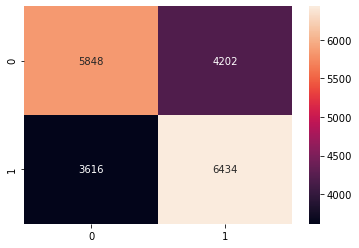

In [37]:
cm_train = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm_train, annot=True, fmt='d')
plt.show()

### How it looks like on test data

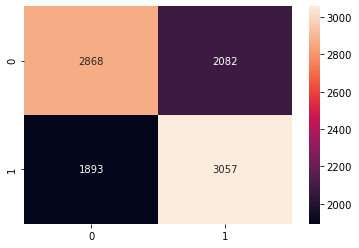

In [38]:
cm_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_test, annot=True, fmt='d')
plt.show()

## Checking inmportance of column in training set using PCA

## Find the most important features - explain variance

In [39]:

# make a new pipeline that does everything
full_pipe = Pipeline(
    [
        ("preprocess", preprocess_pipeline)
        
    ]
)

# measure model performance using cross-validation
scaler = StandardScaler()
pca = PCA()
X_train_proc = full_pipe.fit_transform(X_train)
X_train_scaler = scaler.fit_transform(X_train_proc)

X_pca = pca.fit_transform(X_train_scaler)
total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_over_95 = len(total_explained_variance[total_explained_variance >= .95])
n_to_reach_95 = X_train.shape[1] - n_over_95 + 1
print("Number features: {}\tTotal Variance Explained: {}".format(n_to_reach_95, total_explained_variance[n_to_reach_95 - 1]))

Number features: 14	Total Variance Explained: 0.21444126013723624


In [42]:
pipe = Pipeline([('preprocess', preprocess_pipeline),
 ('pca', PCA(n_components=n_to_reach_95)),
 ('clf', RandomForestClassifier())])
pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['disbursed_amount',
                                                   'asset_cost', 'ltv',
                                                   'branch_id', 'supplier_id',
                                                   'manufacturer_id',
                                                   'Current_pincode_ID',
                                                   'Date.of.Birth', 'State_ID',
                                                   'Employee_code_ID',
                                     

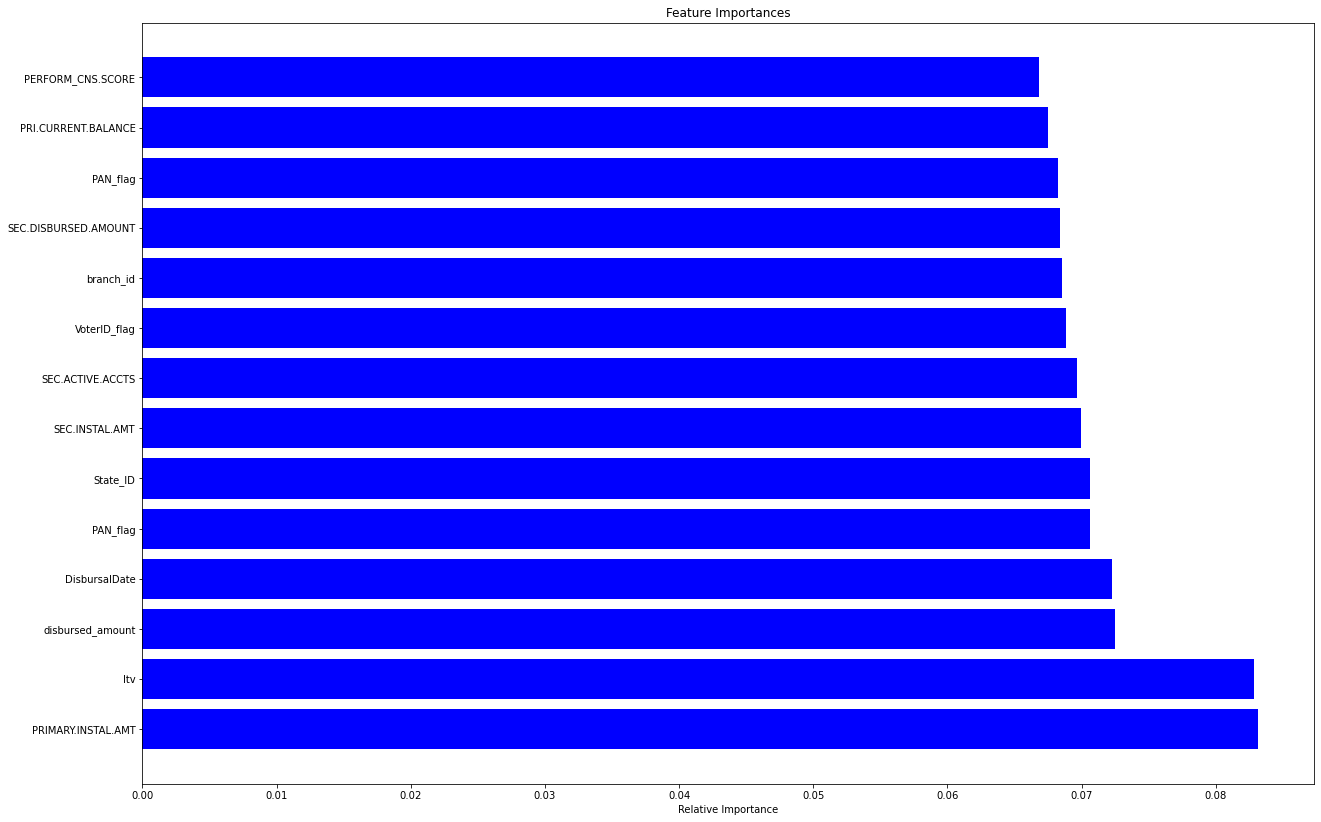

In [43]:
model = pipe.steps[1][1]
n_pcs= model.components_.shape[0]
initial_feature_names = X_train.columns
most_important = [np.abs(model.components_[i]).argmax() for i in     range(n_pcs)]
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
zipped_feats = zip(most_important_names, pipe.steps[2][1].feature_importances_)
zipped_feats = sorted(zipped_feats, key=lambda x: x[1], reverse=True)
features, importances = zip(*zipped_feats)
top_features = features[:14]
top_importances = importances[:14]
plt.figure(figsize=(21,14)) 
plt.title('Feature Importances')
plt.barh(range(len(top_importances)), top_importances, color='b', align='center')
plt.yticks(range(len(top_importances)), top_features)
plt.xlabel('Relative Importance')
plt.show()

### Chceking does PCA help

In [44]:
pipe_log = Pipeline([('preprocess', preprocess_pipeline),
 ('scaler', StandardScaler()),
 ('pca', PCA(n_components=n_to_reach_95)),
 ('log', LogisticRegression(C=1.0, max_iter=10000))])




logreg001 = pipe_log.fit(X_train,y_train)

print("Training set score: {:.3f}".format(logreg001.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg001.score(X_test, y_test)))

print(f'f1 score {metrics.f1_score(y_test , logreg001.predict(X_test))}')

print(f'accuracy_score {metrics.accuracy_score(y_test , logreg001.predict(X_test))}')
print("roc_auc_score: {}".format( metrics.roc_auc_score(y_test , logreg001.predict_proba(X_test)[:,1]) ))

Training set score: 0.580
Test set score: 0.573
f1 score 0.5840307177316136
accuracy_score 0.5732323232323232
roc_auc_score: 0.605778389960208


In [45]:
y_pred_train = logreg001.predict(X_train)
y_pred_test = logreg001.predict(X_test)

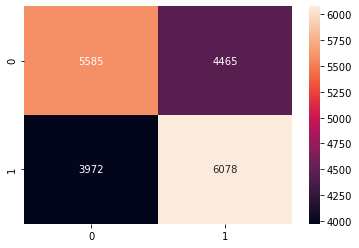

In [46]:
cm_train = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm_train, annot=True, fmt='d')
plt.show()

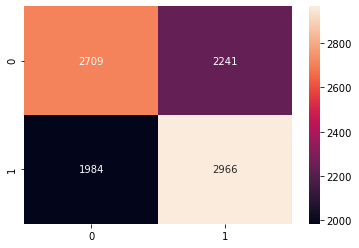

In [47]:
cm_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_test, annot=True, fmt='d')
plt.show()

PCA in that case does not help that's why I'll not use it in the models

# Creating models

In [48]:
seed=123
kfold = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)

## LinearSVC

In [49]:

pipe = Pipeline([('preprocessing', preprocess_pipeline),
                 ('classifier', LinearSVC(C=1,max_iter=20000))])

param_grid = {
            'classifier__C': [ 0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000] # in test split 0.2 the best is 0,1 , IN SPLIT 0.33 10 or 0.1
            
}

grid_1 = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True)

grid_1.fit(X_train, y_train)
grid_1.best_params_


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

{'classifier__C': 0.01}

### Checking  Confusion Matrix for LinearSVC

#### Checking using train data

In [50]:
y_train_pred = cross_val_predict(grid_1, X_train, y_train, cv=5)
y_train_pred.mean(axis=0)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

0.5361691542288557

In [131]:
y_pred_train = grid_1.predict(X_train)
y_pred_test = grid_1.predict(X_test)

print("Training set score: {:.3f}".format(grid_1.score(X_train, y_train)))
print("Test set score: {:.3f}".format(grid_1.score(X_test, y_test)))

print(f'f1 score {metrics.f1_score(y_test , grid_1.predict(X_test))}')

print(f'accuracy_score {metrics.accuracy_score(y_test , grid_1.predict(X_test))}')
print("roc_auc_score: {}".format( metrics.roc_auc_score(y_test , grid_1.decision_function(X_test)) )) 

Training set score: 0.611
Test set score: 0.600
f1 score 0.6097585017249877
accuracy_score 0.6001010101010101
roc_auc_score: 0.6356824405672891


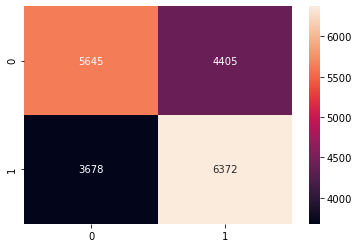

In [52]:
cm_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d')
plt.show()

#### Checking using test data

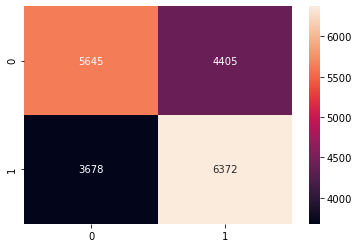

In [53]:
cm_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d')
plt.show()

## LogisticRegression

In [54]:
pipe_3 = Pipeline([('preprocessing', preprocess_pipeline),
                  
                   ('classifier', LogisticRegression(C=1,penalty='l2', max_iter=10000))
                  ])

param_grid_3 = {
            'classifier__C': [0.1,1,10,100,10000,100000] 
            
}

grid_3 = GridSearchCV(pipe_3, param_grid_3, cv=kfold, return_train_score=True)

grid_3.fit(X_train, y_train)
grid_3.best_params_

{'classifier__C': 100}

### Checking  Confusion Matrix for Logistic Regression

#### Checking using train data

In [55]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(grid_3, X_train, y_train, cv=3)
y_train_pred.mean(axis=0)

0.5319900497512438

In [56]:
y_pred_train = grid_3.predict(X_train)
y_pred_test = grid_3.predict(X_test)

print("Training set score: {:.3f}".format(grid_3.score(X_train, y_train)))
print("Test set score: {:.3f}".format(grid_3.score(X_test, y_test)))

print(f'f1 score {metrics.f1_score(y_test , grid_3.predict(X_test))}')

print(f'accuracy_score {metrics.accuracy_score(y_test , grid_3.predict(X_test))}')
print("roc_auc_score: {}".format( metrics.roc_auc_score(y_test , grid_3.predict_proba(X_test)[:,1]) ))

Training set score: 0.611
Test set score: 0.598
f1 score 0.6055500495540138
accuracy_score 0.597979797979798
roc_auc_score: 0.6350197734925007


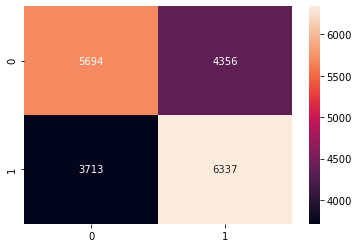

In [57]:
cm_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d')
plt.show()

#### Checking using test data

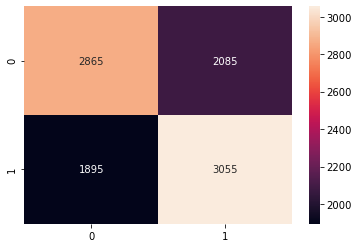

In [58]:
cm_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_test, annot=True, fmt='d')
plt.show()

# KNeighborsClassifier

In [64]:
# from sklearn.neighbors import KNeighborsClassifier

pipe_4 = Pipeline([('preprocessing', preprocess_pipeline),
                   ('classifier', KNeighborsClassifier(n_neighbors=2, metric='euclidean'))
                  ])



param_grid_4 = {
            'classifier__n_neighbors':list(range(1,20)), #[ 30,40,50,60],
            'classifier__metric': ['euclidean']
}


grid_4 = GridSearchCV(pipe_4, param_grid_4, cv=kfold, return_train_score=True)

grid_4.fit(X_train, y_train)
grid_4.best_params_

{'classifier__metric': 'euclidean', 'classifier__n_neighbors': 17}

### Checking Confusion Matrix for KNeighborsClassifier

####  Checking using train data

In [65]:
y_train_pred = cross_val_predict(grid_4, X_train, y_train, cv=3)
y_train_pred.mean(axis=0)

0.5258208955223881

In [66]:
y_pred_train = grid_4.predict(X_train)
y_pred_test = grid_4.predict(X_test)

print("Training set score: {:.3f}".format(grid_4.score(X_train, y_train)))
print("Test set score: {:.3f}".format(grid_4.score(X_test, y_test)))

print(f'f1 score {metrics.f1_score(y_test , grid_4.predict(X_test))}')

print(f'accuracy_score {metrics.accuracy_score(y_test , grid_4.predict(X_test))}')
print("roc_auc_score: {}".format( metrics.roc_auc_score(y_test , grid_4.predict_proba(X_test)[:,1]) ))

Training set score: 0.639
Test set score: 0.568
f1 score 0.576072950738428
accuracy_score 0.567979797979798
roc_auc_score: 0.5882904193449647


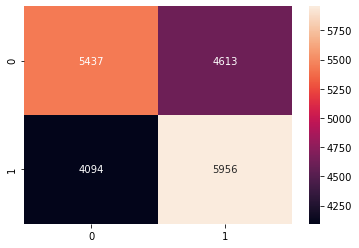

In [67]:
cm_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d')
plt.show()

####  Checking using test data

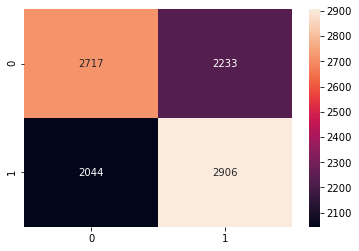

In [68]:
cm_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_test, annot=True, fmt='d')
plt.show()

## DecisionTreeClassifier

In [69]:


pipe_5 = Pipeline([('preprocessing', preprocess_pipeline), 
                   ('classifier', DecisionTreeClassifier())
                  ])

param_grid_5 = {
            'classifier__max_depth': [1,2,3,5],
            'classifier__max_leaf_nodes': [4,5,6,7,8,9,10],
            'classifier__min_samples_split': [2,3,4,5,6]
            
}


grid_5 = GridSearchCV(pipe_5, param_grid_5, cv=kfold, return_train_score=True)

grid_5.fit(X_train, y_train)
grid_5.best_params_

{'classifier__max_depth': 5,
 'classifier__max_leaf_nodes': 9,
 'classifier__min_samples_split': 2}

### Checking Confusion Matrix for DecisionTreeClassifier

####  Checking using train data

In [70]:
y_train_pred = cross_val_predict(grid_5, X_train, y_train, cv=3)
y_train_pred.mean(axis=0)

0.6022388059701492

In [71]:
y_pred_train = grid_5.predict(X_train)
y_pred_test = grid_5.predict(X_test)

print("Training set score: {:.3f}".format(grid_5.score(X_train, y_train)))
print("Test set score: {:.3f}".format(grid_5.score(X_test, y_test)))

print(f'f1 score {metrics.f1_score(y_test , grid_5.predict(X_test))}')

print(f'accuracy_score {metrics.accuracy_score(y_test , grid_5.predict(X_test))}')
print("roc_auc_score: {}".format( metrics.roc_auc_score(y_test , grid_5.predict_proba(X_test)[:,1]) ))

Training set score: 0.585
Test set score: 0.574
f1 score 0.5875673029858052
accuracy_score 0.5744444444444444
roc_auc_score: 0.5965335782063055


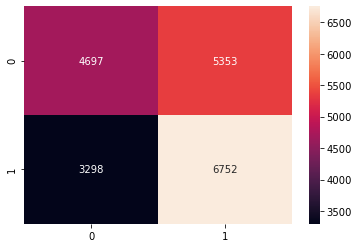

In [72]:
cm_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d')
plt.show()

####  Checking using test data

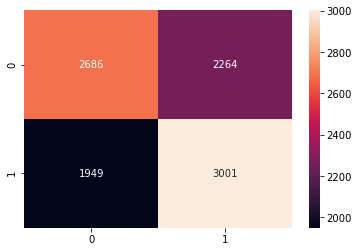

In [73]:
cm_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_test, annot=True, fmt='d')
plt.show()

## BaggingClassifier

In [74]:


pipe_6 = Pipeline([('preprocessing', preprocess_pipeline),
                   ('classifier', BaggingClassifier(
                                    DecisionTreeClassifier(random_state=42), n_estimators=500,
                                    max_samples=1000, bootstrap=True, random_state=42))
                  ])

param_grid_6 = {'classifier__max_samples': [25,50,100,300,500,800],
                'classifier__n_estimators': [50,100,200,400,1000]
              
             }

grid_6 = GridSearchCV(pipe_6, param_grid_6, cv=kfold, return_train_score=True)

grid_6.fit(X_train, y_train)
grid_6.best_params_

{'classifier__max_samples': 800, 'classifier__n_estimators': 400}

### Checking Confusion Matrix for BaggingClassifier

####  Checking using train data

In [75]:
y_train_pred = cross_val_predict(grid_6, X_train, y_train, cv=3)
y_train_pred.mean(axis=0)

0.5213432835820896

In [76]:
y_pred_train = grid_6.predict(X_train)
y_pred_test = grid_6.predict(X_test)

print("Training set score: {:.3f}".format(grid_6.score(X_train, y_train)))
print("Test set score: {:.3f}".format(grid_6.score(X_test, y_test)))

print(f'f1 score {metrics.f1_score(y_test , grid_6.predict(X_test))}')

print(f'accuracy_score {metrics.accuracy_score(y_test , grid_6.predict(X_test))}')
print("roc_auc_score: {}".format( metrics.roc_auc_score(y_test , grid_6.predict_proba(X_test)[:,1]) ))

Training set score: 0.664
Test set score: 0.606
f1 score 0.6156576612108066
accuracy_score 0.6062626262626263
roc_auc_score: 0.6431468625650444


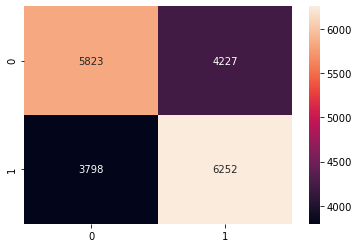

In [77]:
cm_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d')
plt.show()

####  Checking using test data

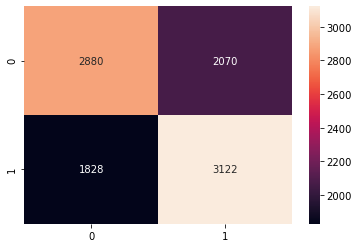

In [78]:
cm_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_test, annot=True, fmt='d')
plt.show()

## RandomForestClassifier

In [96]:


pipe_7 = Pipeline([('preprocessing', preprocess_pipeline), 
                   ('classifier', RandomForestClassifier(n_estimators=500, max_leaf_nodes=16))
                  ])

param_grid_7 = {'classifier__n_estimators': [20,30,40,100,400,800,1400],
              'classifier__max_leaf_nodes': [2,20,15,30,50,100],
              'classifier__max_depth': [2,5,10,20]
             }

grid_7 = GridSearchCV(pipe_7, param_grid_7, cv=kfold, return_train_score=True)

grid_7.fit(X_train, y_train)
grid_7.best_params_
#\n{'classifier__max_depth': 5,\n 'classifier__max_leaf_nodes': 10,\n 'classifier__n_estimators': 10}\n "

{'classifier__max_depth': 20,
 'classifier__max_leaf_nodes': 100,
 'classifier__n_estimators': 800}

### Checking Confusion Matrix for RandomForestClassifier

####  Checking using train data

In [97]:
y_train_pred = cross_val_predict(pipe_7, X_train, y_train, cv=5)
y_train_pred.mean(axis=0)

0.5420398009950249

In [98]:
y_pred_train = pipe_7.fit(X_train, y_train)
y_pred_train.predict(X_train)
y_pred_test = pipe_7.predict(X_test)

print("Training set score: {:.3f}".format(pipe_7.score(X_train, y_train)))
print("Test set score: {:.3f}".format(pipe_7.score(X_test, y_test)))

print(f'f1 score {metrics.f1_score(y_test , pipe_7.predict(X_test))}')

print(f'accuracy_score {metrics.accuracy_score(y_test , pipe_7.predict(X_test))}')
print("roc_auc_score: {}".format( metrics.roc_auc_score(y_test , pipe_7.predict_proba(X_test)[:,1]) ))

Training set score: 0.609
Test set score: 0.594
f1 score 0.6087295401402961
accuracy_score 0.5943434343434344
roc_auc_score: 0.6290635037241098


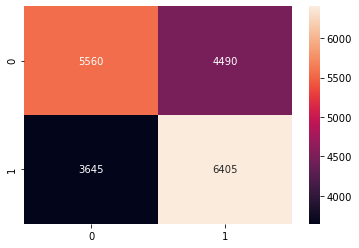

In [99]:
cm_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d')
plt.show()

####  Checking using test data

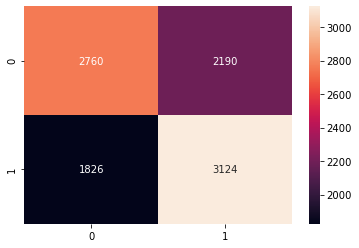

In [100]:
cm_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_test, annot=True, fmt='d')
plt.show()

## ExtraTreesClassifier

In [91]:


pipe_8 = Pipeline([('preprocessing', preprocess_pipeline), 
                   ('classifier', ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16))
                  ])

param_grid_8 = {'classifier__max_depth': [5,6,7,8,9,10,15,20],
                'classifier__max_leaf_nodes': [20,25,50,100],
                'classifier__n_estimators': [10,20,40,52,53,54,60]
              
              
             }

grid_8 = GridSearchCV(pipe_8, param_grid_8, cv=kfold, return_train_score=True)

grid_8.fit(X_train, y_train)
grid_8.best_params_

{'classifier__max_depth': 15,
 'classifier__max_leaf_nodes': 100,
 'classifier__n_estimators': 52}

### Checking Confusion Matrix for ExtraTreesClassifier

####  Checking using train data

In [92]:
y_train_pred = cross_val_predict(grid_8, X_train, y_train, cv=5)
y_train_pred.mean(axis=0)

0.5458706467661691

In [93]:
y_pred_train = grid_8.predict(X_train)
y_pred_test = grid_8.predict(X_test)

print("Training set score: {:.3f}".format(grid_8.score(X_train, y_train)))
print("Test set score: {:.3f}".format(grid_8.score(X_test, y_test)))

print(f'f1 score {metrics.f1_score(y_test , grid_8.predict(X_test))}')

print(f'accuracy_score {metrics.accuracy_score(y_test , grid_8.predict(X_test))}')
print("roc_auc_score: {}".format( metrics.roc_auc_score(y_test , grid_8.predict_proba(X_test)[:,1]) ))

Training set score: 0.642
Test set score: 0.589
f1 score 0.6049310813434284
accuracy_score 0.5888888888888889
roc_auc_score: 0.6186838077747169


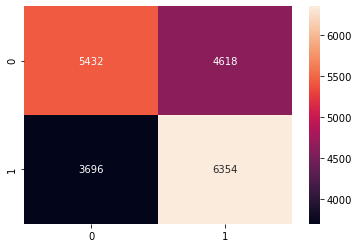

In [94]:
cm_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d')
plt.show()

####  Checking using test data

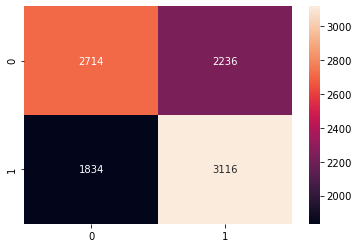

In [95]:
cm_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_test, annot=True, fmt='d')
plt.show()

## GradientBoostingClassifier

In [101]:


pipe_9 = Pipeline([('preprocessing', preprocess_pipeline),
                   ('classifier', GradientBoostingClassifier(
                       n_estimators=1, 
                      learning_rate=0.5, 
                      random_state=42))
                  ])


param_grid_9 = {'classifier__n_estimators': [100,120,150,200,400,500,1000,1500],
              'classifier__learning_rate': [0.001,0.1,1,10,100,1000]
             }

grid_9 = GridSearchCV(pipe_9, param_grid_9, cv=kfold, return_train_score=True)

grid_9.fit(X_train, y_train)
grid_9.best_params_

{'classifier__learning_rate': 0.1, 'classifier__n_estimators': 500}

### Checking Confusion Matrix for GradientBoostingClassifier

####  Checking using train data

In [102]:
y_train_pred = cross_val_predict(grid_9, X_train, y_train, cv=3)
y_train_pred.mean(axis=0)

0.5399004975124378

In [103]:
y_pred_train = grid_9.predict(X_train)
y_pred_test = grid_9.predict(X_test)

print("Training set score: {:.3f}".format(grid_9.score(X_train, y_train)))
print("Test set score: {:.3f}".format(grid_9.score(X_test, y_test)))

print(f'f1 score {metrics.f1_score(y_test , grid_9.predict(X_test))}')

print(f'accuracy_score {metrics.accuracy_score(y_test , grid_9.predict(X_test))}')
print("roc_auc_score: {}".format( metrics.roc_auc_score(y_test , grid_9.predict_proba(X_test)[:,1]) ))

Training set score: 0.701
Test set score: 0.608
f1 score 0.6185181540883598
accuracy_score 0.6083838383838384
roc_auc_score: 0.648542720130599


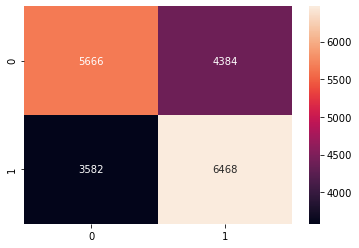

In [104]:
cm_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d')
plt.show()

####  Checking using test data

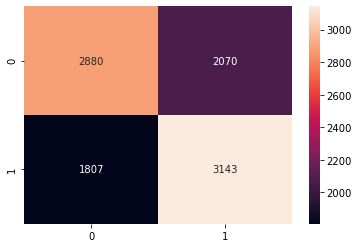

In [105]:
cm_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_test, annot=True, fmt='d')
plt.show()

##  R XgBoos

In [107]:

pipe_10 = Pipeline([('preprocessing', preprocess_pipeline),
                   ('classifier', xgboost.XGBClassifier(n_estimators=1, 
                      learning_rate=0.5, 
                      random_state=42))
                  ])


param_grid_10 = {
    'classifier__colsample_bytree': uniform(0.5, 0.5),
    'classifier__gamma': uniform(0,2),
    'classifier__learning_rate': uniform(0.001, 0.1-0.001),
    'classifier__max_depth': randint(3, 11),
    'classifier__min_child_weight': randint(1, 11),
    'classifier__n_estimators': randint(50, 400), 
    'classifier__subsample': uniform(0.5, 0.5),
    
}

grid_10 = RandomizedSearchCV(n_iter=100,estimator=pipe_10, 
                             param_distributions=param_grid_10, 
                      cv=kfold, 
                      return_train_score=True)

grid_10.fit(X_train, y_train)
grid_10.best_params_

{'classifier__colsample_bytree': 0.5991477907856013,
 'classifier__gamma': 0.6516779597840481,
 'classifier__learning_rate': 0.04011590602094974,
 'classifier__max_depth': 5,
 'classifier__min_child_weight': 3,
 'classifier__n_estimators': 341,
 'classifier__subsample': 0.5038884731315251}

### Checking Confusion Matrix for R XgBoost

####  Checking using train data

In [108]:
y_train_pred = cross_val_predict(grid_10, X_train, y_train, cv=3)
y_train_pred.mean(axis=0)

0.5359701492537313

In [109]:
y_pred_train = grid_10.predict(X_train)
y_pred_test = grid_10.predict(X_test)

print("Training set score: {:.3f}".format(grid_10.score(X_train, y_train)))
print("Test set score: {:.3f}".format(grid_10.score(X_test, y_test)))

print(f'f1 score {metrics.f1_score(y_test , grid_10.predict(X_test))}')

print(f'accuracy_score {metrics.accuracy_score(y_test , grid_10.predict(X_test))}')
print("roc_auc_score: {}".format( metrics.roc_auc_score(y_test , grid_10.predict_proba(X_test)[:,1]) ))

Training set score: 0.695
Test set score: 0.612
f1 score 0.6236390387444826
accuracy_score 0.6124242424242424
roc_auc_score: 0.6551922456892154


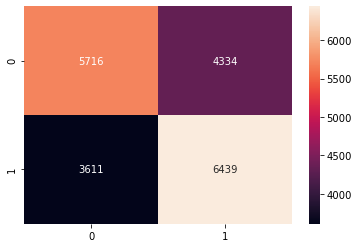

In [110]:
cm_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d')
plt.show()

####  Checking using test data

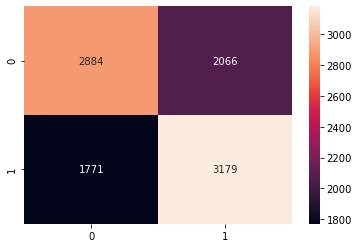

In [111]:
cm_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_test, annot=True, fmt='d')
plt.show()

## xgboost

In [112]:




pipe_11 = Pipeline([('preprocessing', preprocess_pipeline),
                   ('classifier', xgboost.XGBClassifier(n_estimators=1, 
                      learning_rate=0.5, 
                      random_state=42))
                  ])


param_grid_11 ={
    'classifier__subsample': [ 0.8,0.9,1,1.1],
    'classifier__n_estimators': [50, 100,200,500,1000],
    'classifier__min_child_weight': [ 50,100,500,750,1000],
    'classifier__max_depth': [2,3, 4],
    'classifier__learning_rate': [0.001, 0.01,  0.1,1,10,100],
    'classifier__gamma': [0,0.1, 0.5, 1, 2],
    'classifier__colsample_bytree': [  0.5,0.9,1.5,2]
}

grid_11 = RandomizedSearchCV(n_iter=100,estimator=pipe_11, 
                             param_distributions=param_grid_11, 
                      cv=kfold, 
                      return_train_score=True)

grid_11.fit(X_train, y_train)
grid_11.best_params_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

{'classifier__subsample': 0.8,
 'classifier__n_estimators': 200,
 'classifier__min_child_weight': 100,
 'classifier__max_depth': 4,
 'classifier__learning_rate': 0.1,
 'classifier__gamma': 2,
 'classifier__colsample_bytree': 0.9}

### Checking Confusion Matrix for xgboost

#### Checking using train data

In [113]:
y_train_pred = cross_val_predict(grid_11, X_train, y_train, cv=5)
y_train_pred.mean(axis=0)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.55578358        nan        nan 0.60385572
 0.5               nan        nan        nan        nan        nan
        nan 0.5               nan 0.5596393         nan 0.5
        nan 0.5        0.5        0.5               nan        nan
 0.58072139        nan        nan        nan        nan        nan
 0.5               nan        nan        nan 0.5        0.59894279
        nan        nan        nan        nan 0.58886816        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.5931592  0.57587065        nan
 0.55534826 0.5               nan        nan        nan        nan
        nan        nan        nan 0.5        0.58855721 0.57717662
        nan        nan        nan 0.5               nan        nan
 0.57717662        nan        nan        nan 0.60118159     

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

0.5302487562189054

In [114]:
y_pred_train = grid_11.predict(X_train)
y_pred_test = grid_11.predict(X_test)


print("Training set score: {:.3f}".format(grid_11.score(X_train, y_train)))
print("Test set score: {:.3f}".format(grid_11.score(X_test, y_test)))

print(f'f1 score {metrics.f1_score(y_test , grid_11.predict(X_test))}')

print(f'accuracy_score {metrics.accuracy_score(y_test , grid_11.predict(X_test))}')
print("roc_auc_score: {}".format( metrics.roc_auc_score(y_test , grid_11.predict_proba(X_test)[:,1]) ))

Training set score: 0.651
Test set score: 0.612
f1 score 0.6223315297589768
accuracy_score 0.6122222222222222
roc_auc_score: 0.6521842873176206


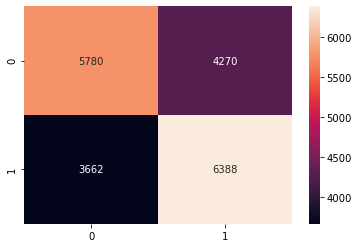

In [115]:
cm_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d')
plt.show()

#### Checking using test data

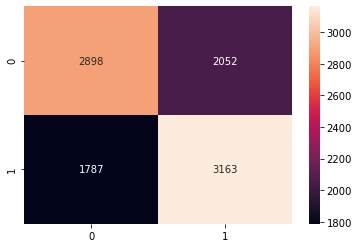

In [116]:
cm_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_test, annot=True, fmt='d')
plt.show()

## AdaBoostClassifier

In [117]:

pipe_12 = Pipeline([('preprocessing', preprocess_pipeline), 
                   ('classifier', AdaBoostClassifier(
                        DecisionTreeClassifier(max_depth=1), 
                        n_estimators=1,
                        learning_rate=0.5, 
                        algorithm="SAMME.R",
                        random_state=42)
                   )
                  ])


param_grid_12 = {'classifier__n_estimators': [30,40,50,52],
              'classifier__learning_rate': [0.1, 0.2,0.5,0.8,0.9, 1],
             }

grid_12 = GridSearchCV(pipe_12, param_grid_12, cv=kfold, return_train_score=True)

grid_12.fit(X_train, y_train)
grid_12.best_params_

{'classifier__learning_rate': 0.9, 'classifier__n_estimators': 40}

### Checking Confusion Matrix for AdaBoostClassifier

####  Checking using train data

In [118]:
y_train_pred = cross_val_predict(grid_12, X_train, y_train, cv=3)
y_train_pred.mean(axis=0)

0.5292039800995025

In [119]:
y_pred_train = grid_12.predict(X_train)
y_pred_test = grid_12.predict(X_test)

print("Training set score: {:.3f}".format(grid_12.score(X_train, y_train)))
print("Test set score: {:.3f}".format(grid_12.score(X_test, y_test)))

print(f'f1 score {metrics.f1_score(y_test , grid_12.predict(X_test))}')

print(f'accuracy_score {metrics.accuracy_score(y_test , grid_12.predict(X_test))}')
print("roc_auc_score: {}".format( metrics.roc_auc_score(y_test , grid_12.predict_proba(X_test)[:,1]) ))

Training set score: 0.609
Test set score: 0.599
f1 score 0.6063492063492064
accuracy_score 0.5991919191919192
roc_auc_score: 0.6391666360575452


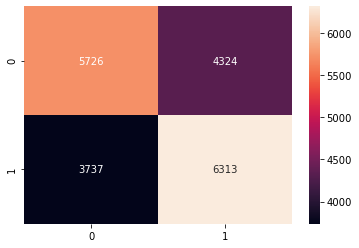

In [120]:
cm_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d')
plt.show()

####  Checking using test data

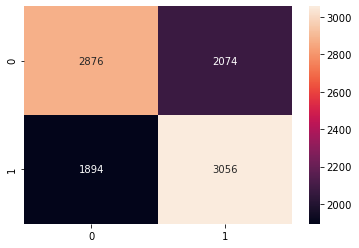

In [121]:
cm_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_test, annot=True, fmt='d')
plt.show()

## VotingClassifier

In [122]:
voting_clf = VotingClassifier(
    estimators=[
                ('grid_5', grid_5.best_estimator_), 
                ('grid_6', grid_6.best_estimator_), 
                ('grid_8', grid_8.best_estimator_),
                ('grid_9', grid_9.best_estimator_),
               ],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('grid_5',
                              Pipeline(steps=[('preprocessing',
                                               ColumnTransformer(transformers=[('num',
                                                                                Pipeline(steps=[('simpleimputer',
                                                                                                 SimpleImputer(strategy='median')),
                                                                                                ('standardscaler',
                                                                                                 StandardScaler())]),
                                                                                ['disbursed_amount',
                                                                                 'asset_cost',
                                                                                 'ltv',
                                              

### Checking Confusion Matrix for VotingClassifier

####  Checking using train data

In [123]:
y_train_pred = cross_val_predict(voting_clf, X_train, y_train, cv=3)
y_train_pred.mean(axis=0)

0.5404477611940298

In [124]:
y_pred_train = voting_clf.predict(X_train)
y_pred_test = voting_clf.predict(X_test)

print("Training set score: {:.3f}".format(voting_clf.score(X_train, y_train)))
print("Test set score: {:.3f}".format(voting_clf.score(X_test, y_test)))

print(f'f1 score {metrics.f1_score(y_test , voting_clf.predict(X_test))}')

print(f'accuracy_score {metrics.accuracy_score(y_test , voting_clf.predict(X_test))}')
print("roc_auc_score: {}".format( metrics.roc_auc_score(y_test , voting_clf.predict_proba(X_test)[:,1]) ))

Training set score: 0.670
Test set score: 0.610
f1 score 0.6305220883534136
accuracy_score 0.6096969696969697
roc_auc_score: 0.6481850831547801


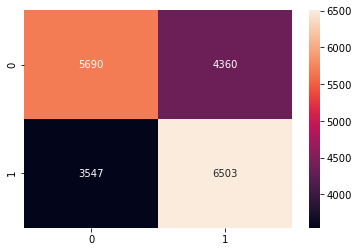

In [125]:
cm_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d')
plt.show()

####  Checking using test data

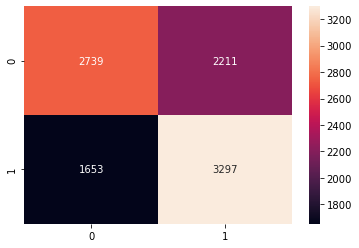

In [126]:
cm_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_test, annot=True, fmt='d')
plt.show()

# Comparison of models on test data

In [127]:

models = []
models.append(('SVM linear', grid_1.best_estimator_))
models.append(('LR', grid_3.best_estimator_))
models.append(('KNN', grid_4.best_estimator_))
models.append(('DecisionTreeClassifier', grid_5.best_estimator_))
models.append(('BaggingClassifier', grid_6.best_estimator_))
models.append(('RandomForestClassifier', grid_7.best_estimator_))
models.append(('ExtraTrees', grid_8.best_estimator_))
models.append(('GrBoos', grid_9.best_estimator_))
models.append(('R XgBoos', grid_10.best_estimator_))
models.append(('XgBoos', grid_11.best_estimator_)) #grid_11
models.append(('AdaBoost', grid_12.best_estimator_))
models.append(('voting_clf', voting_clf))




precision_score = []
recall_score = []
f1_score = []
accuracy_score = []
roc_auc_score = []
for name, model in models:
    print(name)
    print("recall_score: {}".format( metrics.recall_score(y_test , model.predict(X_test)) ))
    print("f1_score: {}".format( metrics.f1_score(y_test , model.predict(X_test)) ))
    print("accuracy_score: {}".format( metrics.accuracy_score(y_test , model.predict(X_test)) ))
    
    if (name == 'SVM linear'):
        print("roc_auc_score: {}".format( metrics.roc_auc_score(y_test , model.decision_function(X_test)) ))            
    else:
        print("roc_auc_score: {}".format( metrics.roc_auc_score(y_test , model.predict_proba(X_test)[:,1]) ))
    
    precision_score.append(metrics.precision_score(y_test , model.predict(X_test)))
    recall_score.append(metrics.recall_score(y_test , model.predict(X_test)))
    f1_score.append( metrics.f1_score(y_test , model.predict(X_test)))
    accuracy_score.append(metrics.accuracy_score(y_test , model.predict(X_test)))
    if (name == 'SVM linear'):
        roc_auc_score.append(metrics.roc_auc_score(y_test , model.decision_function(X_test)))        
    else:    
        roc_auc_score.append(metrics.roc_auc_score(y_test , model.predict_proba(X_test)[:,1]))

SVM linear
recall_score: 0.6248484848484849
f1_score: 0.6097585017249877
accuracy_score: 0.6001010101010101
roc_auc_score: 0.6356824405672891
LR
recall_score: 0.6171717171717171
f1_score: 0.6055500495540138
accuracy_score: 0.597979797979798
roc_auc_score: 0.6350197734925007
KNN
recall_score: 0.5870707070707071
f1_score: 0.576072950738428
accuracy_score: 0.567979797979798
roc_auc_score: 0.5882904193449647
DecisionTreeClassifier
recall_score: 0.6062626262626263
f1_score: 0.5875673029858052
accuracy_score: 0.5744444444444444
roc_auc_score: 0.5965335782063055
BaggingClassifier
recall_score: 0.6307070707070707
f1_score: 0.6156576612108066
accuracy_score: 0.6062626262626263
roc_auc_score: 0.6431468625650444
RandomForestClassifier
recall_score: 0.6406060606060606
f1_score: 0.6166861143523921
accuracy_score: 0.6018181818181818
roc_auc_score: 0.6423291500867259
ExtraTrees
recall_score: 0.6294949494949494
f1_score: 0.6049310813434284
accuracy_score: 0.5888888888888889
roc_auc_score: 0.6186838077

SVM linear
LR
KNN
DecisionTreeClassifier
BaggingClassifier
RandomForestClassifier
ExtraTrees
GrBoos
R XgBoos
XgBoos
AdaBoost
voting_clf


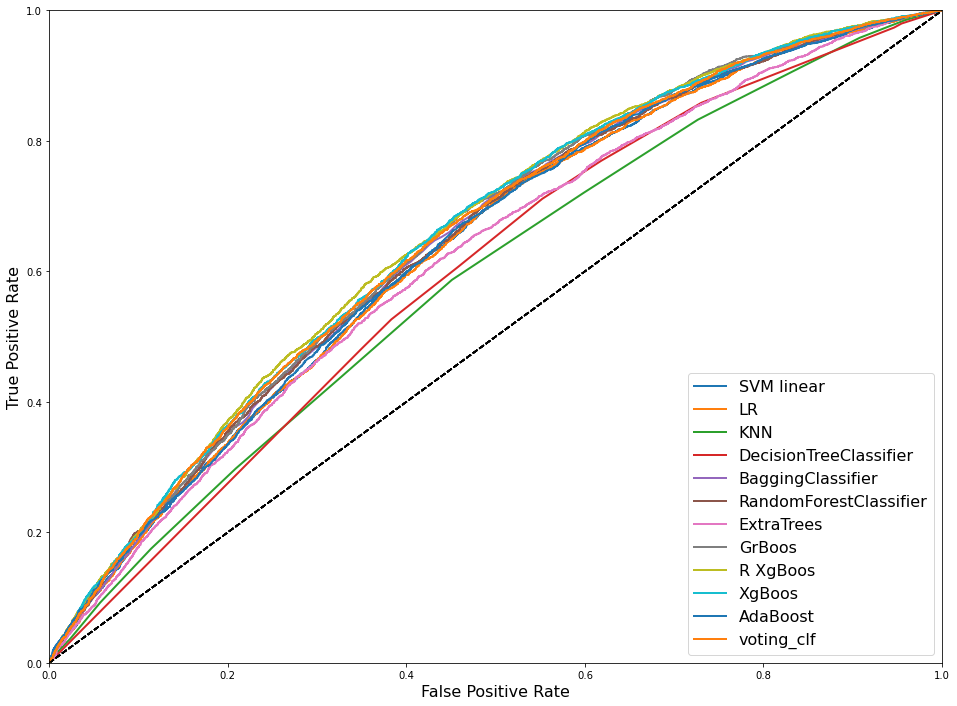

In [128]:


def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(16, 12))
for name, model in models:
    print(name)
    if (name == 'SVM linear'):
        y_scores = model.decision_function(X_test)
    else: 
        y_scores = model.predict_proba(X_test)[:,1]        
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    plot_roc_curve(fpr, tpr, name)

plt.legend(loc="lower right", fontsize=16)
plt.show()

In [129]:
valuse_list = []
for name,model in models:
    valuse_list.append(name)

d = {'precision_score': precision_score, 
     'recall_score': recall_score, 
     'f1_score': f1_score,
     'accuracy_score' : accuracy_score,
     'roc_auc_score' : roc_auc_score
    }
df = pd.DataFrame(data=d)
df.insert(loc=0, column='Method', value=valuse_list)

df

,Method,precision_score,recall_score,f1_score,accuracy_score,roc_auc_score
0,SVM linear,0.595380,0.624848,0.609759,0.600101,0.635682
1,LR,0.594358,0.617172,0.605550,0.597980,0.635020
2,KNN,0.565480,0.587071,0.576073,0.567980,0.588290
3,DecisionTreeClassifier,0.569991,0.606263,0.587567,0.574444,0.596534
4,BaggingClassifier,0.601310,0.630707,0.615658,0.606263,0.643147
5,RandomForestClassifier,0.594488,0.640606,0.616686,0.601818,0.642329
6,ExtraTrees,0.582212,0.629495,0.604931,0.588889,0.618684
7,GrBoos,0.602916,0.634949,0.618518,0.608384,0.648543
8,R XgBoos,0.606101,0.642222,0.623639,0.612424,0.655192
9,XgBoos,0.606520,0.638990,0.622332,0.612222,0.652184


# Conclusions

The best model for this task is R XgBoos with ROC AUC Score = 0.655192, The results could be better if would be possibility tu use whole data - not only 12% (hardware limitations in my case).   